# Import the essential libraries

In [5]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline

# Define the required variable

In [13]:
dataset_url = r'C:\Users\aasis\Documents\Mini Project\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

# Data preparation for the model

In [14]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [4]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [5]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


# Visualization of input datasets

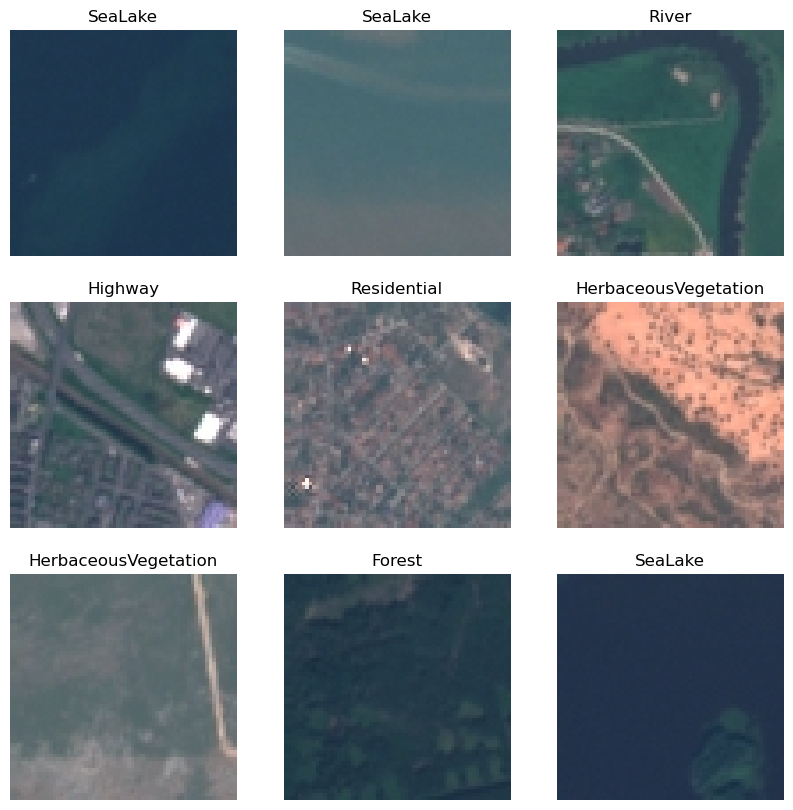

In [6]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50 Model building

In [7]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [8]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# Model train

In [10]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=5, batch_size=32)

C:\Users\aasis\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1810s 2s/step - accuracy: 0.4522 - loss: 1.8978 - val_accuracy: 0.6413 - val_loss: 1.0286
Epoch 2/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1143s 2s/step - accuracy: 0.6835 - loss: 0.9324 - val_accuracy: 0.7331 - val_loss: 0.7904
Epoch 3/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1142s 2s/step - accuracy: 0.7351 - loss: 0.8003 - val_accuracy: 0.1424 - val_loss: 9.9456
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1165s 2s/step - accuracy: 0.6082 - loss: 1.1861 - val_accuracy: 0.5350 - val_loss: 4.2161
Epoch 5/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1224s 2s/step - accuracy: 0.7631 - loss: 0.6975 - val_accuracy: 0.2124 - val_loss: 4.8565


In [22]:
model.save('lulc_20_epoch.keras')

# analyzing results and visualization

NameError: name 'history' is not defined

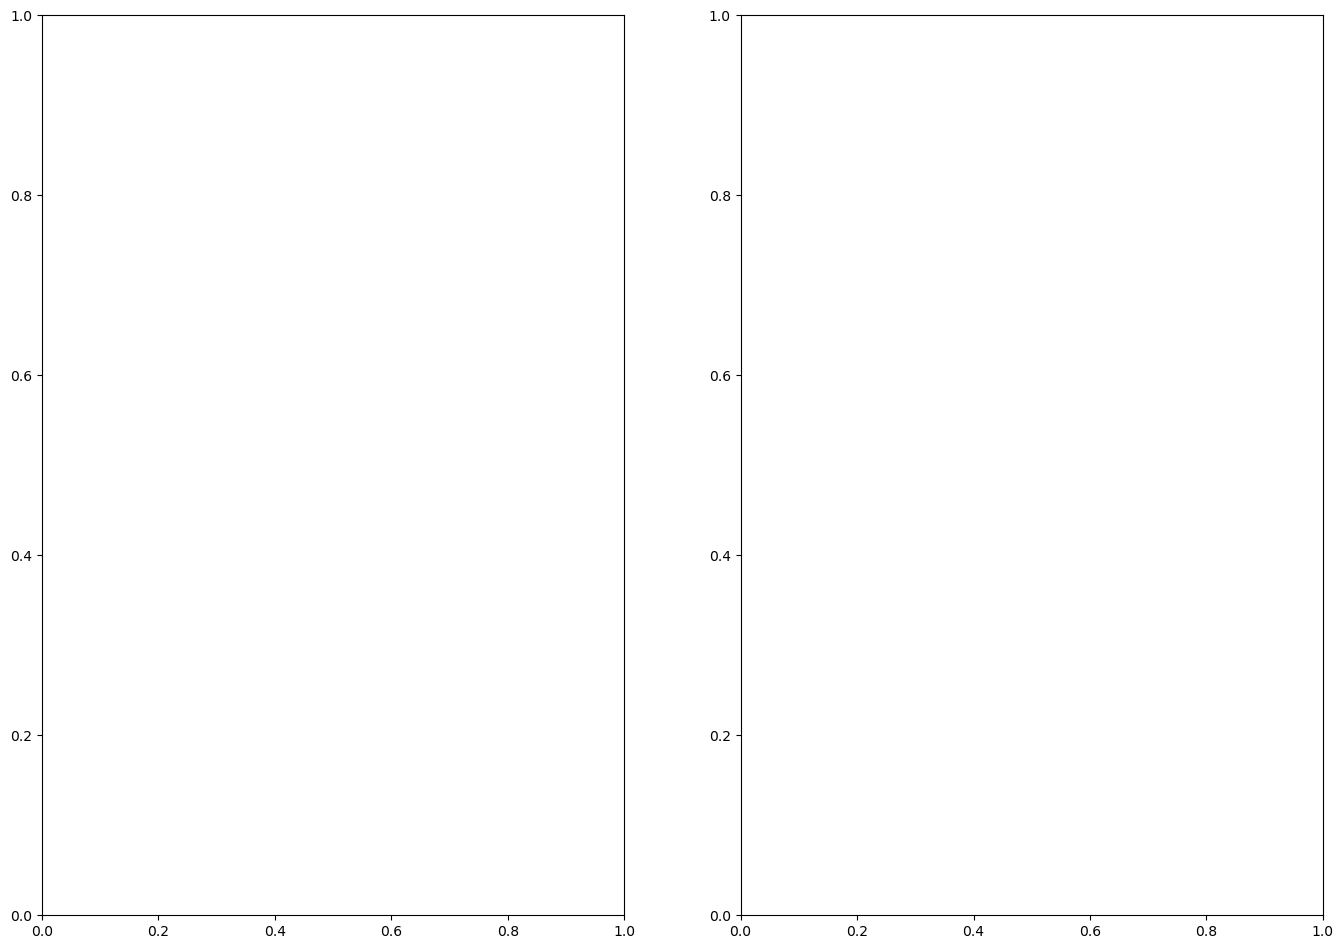

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix

In [3]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

NameError: name 'test_dataset' is not defined

In [16]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 873,    4,   11,   29,    5,   31,   62,    0,   16,   22],
       [   5,  972,    4,    1,    0,   44,    0,    0,    9,   31],
       [  26,   36,  780,   28,   25,   15,   95,   36,   28,    8],
       [  10,    1,   16,  695,   49,   16,   34,   33,   40,    2],
       [   0,    0,    5,   19,  820,    0,    2,   43,   17,    0],
       [  23,   12,   14,   26,    0,  585,   25,    0,   12,   11],
       [  40,    0,  103,   48,   18,   22,  642,   16,    3,    0],
       [   0,    0,   21,   14,   33,    0,    7,  988,    0,    0],
       [  26,   12,   10,   73,    9,   40,   17,    0,  700,    6],
       [   8,   10,    0,    0,    0,    4,    0,    0,    1, 1047]],
      dtype=int64)

In [17]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 873    4   11   29    5   31   62    0   16   22]
 [   5  972    4    1    0   44    0    0    9   31]
 [  26   36  780   28   25   15   95   36   28    8]
 [  10    1   16  695   49   16   34   33   40    2]
 [   0    0    5   19  820    0    2   43   17    0]
 [  23   12   14   26    0  585   25    0   12   11]
 [  40    0  103   48   18   22  642   16    3    0]
 [   0    0   21   14   33    0    7  988    0    0]
 [  26   12   10   73    9   40   17    0  700    6]
 [   8   10    0    0    0    4    0    0    1 1047]]


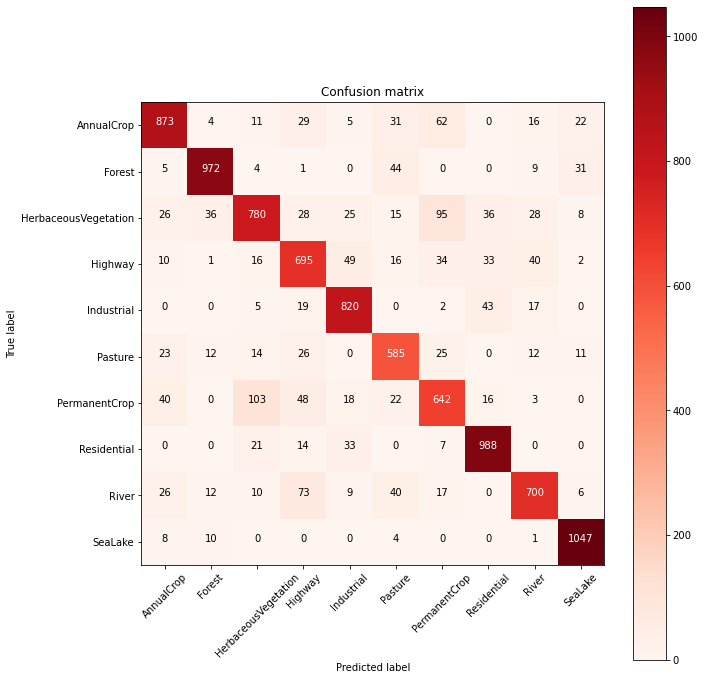

In [18]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

In [31]:
# model = tf.keras.applications.ResNet101(
#     include_top=False,
#     input_tensor=None,
#     input_shape=(64,64, 3),
#     classes=10,
# )
# model.summary()

# Load model

In [3]:
from tensorflow.keras.models import load_model
model = load_model('lulc_20_epoch.keras')

C:\Users\aasis\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 216 variables whereas the saved optimizer has 430 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Load your trained model
model = load_model('lulc_20_epoch.keras')  # Adjust the path as needed

# Step 2: Load and preprocess the input image
def preprocess_image(image_path, target_size):
    """
    Preprocess the input image for model prediction.

    Args:
        image_path (str): Path to the image.
        target_size (tuple): Target size for resizing (height, width).

    Returns:
        numpy.ndarray: Preprocessed image ready for the model.
    """
    # Load the image
    img = load_img(image_path, target_size=target_size)  # Resize the image
    img_array = img_to_array(img)  # Convert image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Step 3: Provide the image path and target size
image_path = (r"D:\mini\test\688913_sat.jpg")  # Replace with your image file path
target_size = (64, 64)  # Replace with the expected input size of your model

preprocessed_image = preprocess_image(image_path, target_size)

# Step 4: Make a prediction
predictions = model.predict(preprocessed_image)

# Step 5: Decode predictions
print("Predictions:", predictions)

predicted_class = np.argmax(predictions[0])
print("Predicted class:", predicted_class)

predicted_probability = predictions[0][predicted_class]
print("Predicted probability:", predicted_probability)


# Class mapping
class_labels = [
    "annualcrop", "forest", "vegetation", "highway", "industrial",
    "pasture", "permanentcrop", "residential", "river", "sealake"
]

# Map the predicted index to a label
predicted_label = class_labels[predicted_class]
print(f"The model predicts the image is: {predicted_label} ({predicted_class})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions: [[2.8538756e-02 5.9336016e-05 1.3673521e-03 1.8082455e-01 2.1767881e-05
  7.2622932e-02 4.3198738e-02 3.0226038e-05 6.7331231e-01 2.4174575e-05]]
Predicted class: 8
Predicted probability: 0.6733123
The model predicts the image is: river (8)


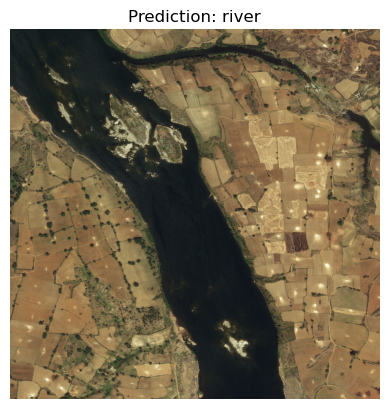

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()
